# Video Game Sales Analysis for Ice

Ice, an international online video game store, aims to enhance its understanding of the factors driving video game success across different platforms, genres, and regions. By analyzing data on game sales, user and critic reviews, platform popularity, and genre performance, Ice seeks to develop strategic insights to inform future game releases and marketing campaigns.

In this project, we explore data on game sales spanning multiple years and regions, focusing on key questions:

* Platform and Genre Trends: Which platforms and genres are most profitable, and how do they vary by region?

* Impact of Reviews on Sales: How do critic and user reviews influence a game’s commercial success?

* Regional Preferences: What are the unique platform, genre, and rating preferences in North America, Europe, and Japan?

* User Ratings Across Platforms and Genres: Are there significant differences in user satisfaction across platforms and genres?

By examining these questions, this analysis provides Ice with actionable insights for targeting future releases, optimizing marketing strategies, and aligning content with the preferences of its global audience. The results of this analysis will help Ice identify potential market winners and strategically plan campaigns that cater to diverse regional and platform choices.

**Note: All sales figures in this dataset are represented in millions of USD.**

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

In [35]:
# Load dataset
games_df = pd.read_csv('games.csv')

In [37]:
# Display general information
print(games_df.info())
print(games_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None
                       Name Platform  Year_of_Release         Genre  NA_sales  \
0                Wii Sports      Wii           2006.0        Sports     41.36   
1         Super Mario Bros.      NES           1985.0      Platform     29

In [39]:
# Data Preparation
games_df.columns = games_df.columns.str.lower()
games_df['year_of_release'] = games_df['year_of_release'].fillna(0).astype(int)
games_df['user_score'] = pd.to_numeric(games_df['user_score'], errors='coerce')
games_df['total_sales'] = games_df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

# Check for duplicates
duplicates_count = games_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates_count}")

# Remove duplicates if any are found
if duplicates_count > 0:
    games_df = games_df.drop_duplicates()
    print("Duplicates have been removed.")
else:
    print("No duplicates found.")

# Here, I'm leaving most missing values as NaN for now; let’s document this decision as we analyze further
# - 'Critic_Score', 'User_Score', and 'Rating' contain many missing entries that may reflect unavailable data

Number of duplicate rows: 0
No duplicates found.


In [41]:
# Display prepared data sample to verify changes
print(games_df.info())
print(games_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16715 non-null  int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
 11  total_sales      16715 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.5+ MB
None
                       name platform  year_of_release         genre  na_sales  \
0                Wii Sports      Wii             2006        Sports     41.36   
1         Super Ma

# Exploratory Data Analysis

## Game Releases by Year

The analysis of game releases over the years reveals key trends in the gaming industry:

**Growth and Peaks:** The data shows periods of growth where game releases increased significantly, often aligning with technological advancements, such as new console generations or the rise of digital distribution.

**Declines:** Years with fewer releases may reflect market saturation, economic factors, or shifts in consumer preferences.

**Recent Trends:** Understanding release patterns helps identify periods of high competition and potential opportunities for timing new releases when the market is less saturated.

Overall, these insights provide historical context, helping predict future release trends and optimal timing for launching new games to capture consumer attention.

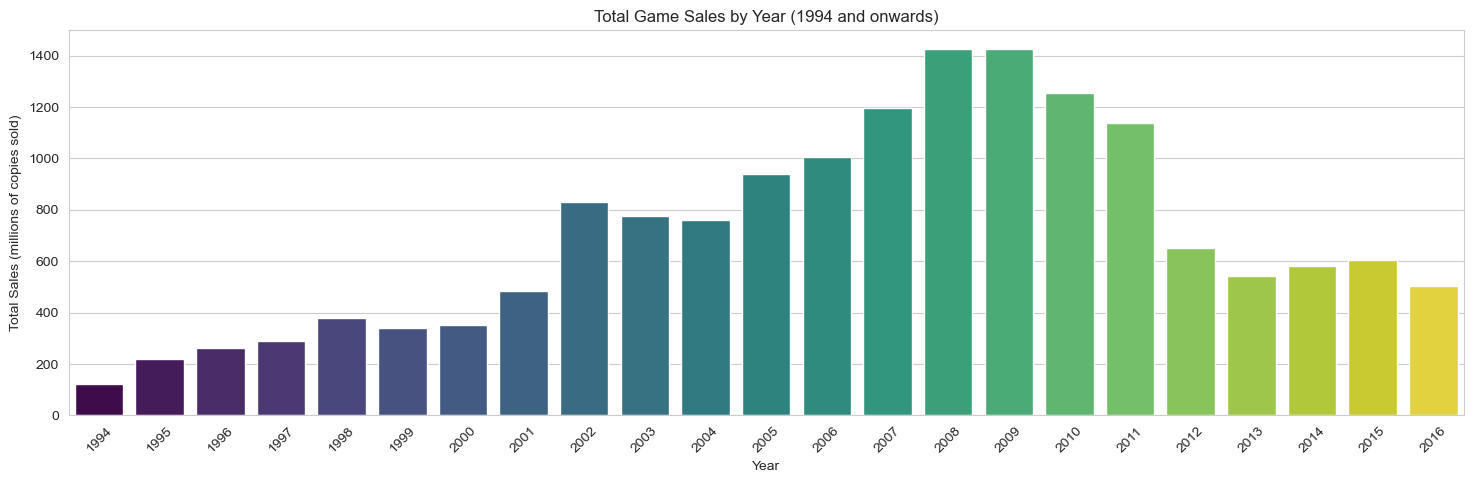

In [44]:
# Group the data by 'year_of_release' and count the number of games released each year
games_sales = games_df.groupby('year_of_release').agg({'name': 'count'})
games_sales = games_sales.rename(columns={'name': 'Number of games sold'})
games_sales.index = games_sales.index.rename('year')

# Filter to include only years from 1990 onwards
games_sales = games_sales[games_sales.index >= 1994]

# Set Seaborn style for better aesthetics
sns.set_style('whitegrid')

# Plot the total game sales by year
plt.figure(figsize=(18, 5))
sns.barplot(x=games_sales.index, y=games_sales['Number of games sold'], palette="viridis", hue=games_sales.index, dodge=False, legend=False)
plt.title("Total Game Sales by Year (1994 and onwards)")
plt.ylabel("Total Sales (millions of copies sold)")
plt.xlabel("Year")
plt.xticks(rotation=45)
plt.show()

## Top Platforms by Sales and Yearly Distribution

Analyzing the yearly sales distribution of top platforms provides insights into each platform's market performance over time:

**Peak Sales Periods:** Each platform’s sales trends reveal peak periods that often align with the early years following a platform's release, suggesting high engagement during its initial lifecycle.

**Platform Longevity:** Some platforms demonstrate extended periods of strong sales, indicating a lasting appeal and a loyal user base, while others experience faster declines as newer platforms emerge.

**Market Shifts:** Platforms with consistent sales over multiple years illustrate stability, while those with steep declines highlight shifts in consumer preference or competition from new technologies.

These insights help identify stable platforms for long-term investment and highlight those nearing the end of their lifecycle, assisting in strategic planning for new game releases.

In [47]:
# Calculate total sales by platform and identify top platforms
platform_sales = games_df.groupby('platform')['total_sales'].sum().sort_values(ascending=False)
top_platforms = platform_sales.head(5).index  # Select the top 5 platforms for analysis

In [49]:
# Filter data for only the top platforms and valid years, and remove invalid DS data
top_platform_data = games_df[
    (games_df['platform'].isin(top_platforms)) &
    (games_df['year_of_release'] >= 1980) &
    ~((games_df['platform'] == 'DS') & (games_df['year_of_release'] < 2004))  # Remove DS entries before 2004
]

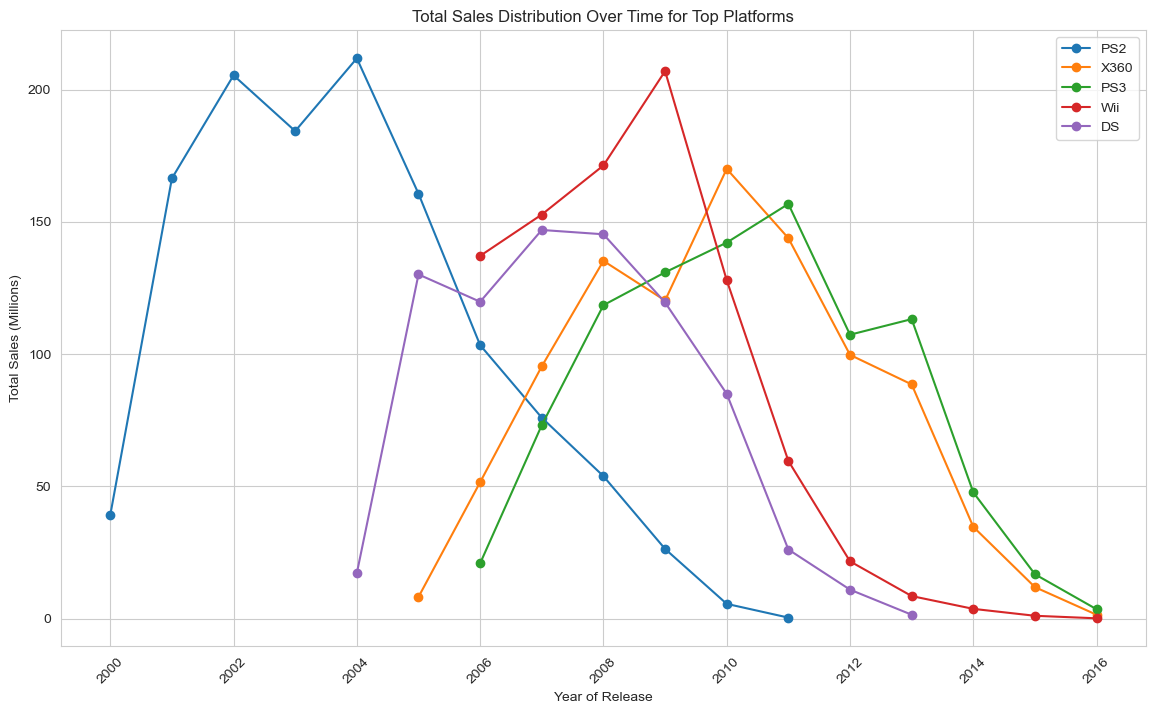

In [51]:
# Plot sales distribution for each top platform by year
plt.figure(figsize=(14, 8))
for platform in top_platforms:
    platform_data = top_platform_data[top_platform_data['platform'] == platform]
    sales_by_year = platform_data.groupby('year_of_release')['total_sales'].sum()
    plt.plot(sales_by_year.index, sales_by_year.values, marker='o', label=platform)

# Labeling the plot
plt.xlabel("Year of Release")
plt.ylabel("Total Sales (Millions)")
plt.title("Total Sales Distribution Over Time for Top Platforms")
plt.legend()
plt.xticks(rotation=45)
plt.show()

## Platform Lifespans

The analysis of platform lifespans provides valuable insights into how long each platform remains relevant and competitive in the gaming market:

**Longevity and Stability:** Platforms with longer lifespans demonstrate a strong market presence and ongoing consumer interest, making them attractive for long-term game development and investment.

**Rapid Turnover:** Platforms with shorter lifespans often face rapid declines, likely due to technological advancements or competition from newer platforms, signaling a higher risk for long-term projects.

**Lifecycle Patterns:** Understanding platform longevity helps in timing releases, as platforms with extended lifespans may support multiple game releases over their lifecycle, maximizing potential sales.

These insights aid in strategic decision-making, helping identify stable platforms for future releases and recognizing those at risk of obsolescence.

In [54]:
# Identify first and last year of sales for each platform
platform_years = games_df.groupby('platform')['year_of_release'].agg(['min', 'max'])
platform_years['lifespan'] = platform_years['max'] - platform_years['min']

In [56]:
# Display platform lifespans to understand how long they tend to stay relevant
print(platform_years.sort_values(by='lifespan', ascending=False))

           min   max  lifespan
platform                      
3DS          0  2016      2016
X360         0  2016      2016
Wii          0  2016      2016
PSV          0  2016      2016
PC           0  2016      2016
PS3          0  2016      2016
PSP          0  2015      2015
DS           0  2013      2013
PS2          0  2011      2011
XB           0  2008      2008
GBA          0  2007      2007
GC           0  2007      2007
PS           0  2003      2003
N64          0  2002      2002
GB           0  2001      2001
2600         0  1989      1989
NES       1983  1994        11
DC        1998  2008        10
SNES      1990  1999         9
SAT       1994  1999         5
WiiU      2012  2016         4
GEN       1990  1994         4
PS4       2013  2016         3
NG        1993  1996         3
XOne      2013  2016         3
WS        1999  2001         2
3DO       1994  1995         1
SCD       1993  1994         1
PCFX      1996  1996         0
TG16      1995  1995         0
GG      

## Top Platforms by Sales (2013 and onward)

**Market Leaders:** The analysis identifies platforms that have consistently dominated the market in recent years (2013-2016), emphasizing their broad appeal and well-established user base. These platforms represent stable and promising options for future game releases due to their sustained popularity and high sales performance.

**Emerging Trends:** The data highlights newer platforms that have shown a clear upward trend in sales, signaling potential growth opportunities. These emerging platforms may warrant strategic investment as they continue gaining traction and establishing themselves among users. This suggests a shift in consumer interest toward platforms with more advanced technology or unique offerings.

**Impact of New Platform Releases:** The introduction of newer platforms appears to have led to a decrease in sales for certain established platforms, reflecting the dynamic nature of consumer preferences and technological advancements in the gaming industry. This trend suggests that some older platforms may be losing relevance as consumers shift their attention to more recent options.

**Strategic Implications:** This analysis equips Ice with critical insights for prioritizing platform selection. By focusing on dominant market leaders and investing in emerging platforms while monitoring trends in diminishing platforms, Ice can strategically target releases that are most likely to yield high returns. Understanding the effects of new platform introductions also enables Ice to anticipate shifts and maintain relevance in a rapidly evolving gaming landscape.

In [59]:
# Filter data for the recent period (e.g., 2013 and onward for a 4-year window)
recent_games_df = games_df[games_df['year_of_release'] >= 2013]

In [61]:
# Verify the filtering worked by checking the minimum year
print(recent_games_df['year_of_release'].min())  # Should be 2013 or later
print(recent_games_df.head())

2013
                         name platform  year_of_release         genre  \
16         Grand Theft Auto V      PS3             2013        Action   
23         Grand Theft Auto V     X360             2013        Action   
31  Call of Duty: Black Ops 3      PS4             2015       Shooter   
33        Pokemon X/Pokemon Y      3DS             2013  Role-Playing   
42         Grand Theft Auto V      PS4             2014        Action   

    na_sales  eu_sales  jp_sales  other_sales  critic_score  user_score  \
16      7.02      9.09      0.98         3.96          97.0         8.2   
23      9.66      5.14      0.06         1.41          97.0         8.1   
31      6.03      5.86      0.36         2.38           NaN         NaN   
33      5.28      4.19      4.35         0.78           NaN         NaN   
42      3.96      6.31      0.38         1.97          97.0         8.3   

   rating  total_sales  
16      M        21.05  
23      M        16.27  
31    NaN        14.63  
33   

In [63]:
# Calculate total sales by platform in the filtered data
top_platform_sales = recent_games_df.groupby('platform')['total_sales'].sum().sort_values(ascending=False)
leading_platforms = top_platform_sales.head(5).index  # Select top 5 platforms

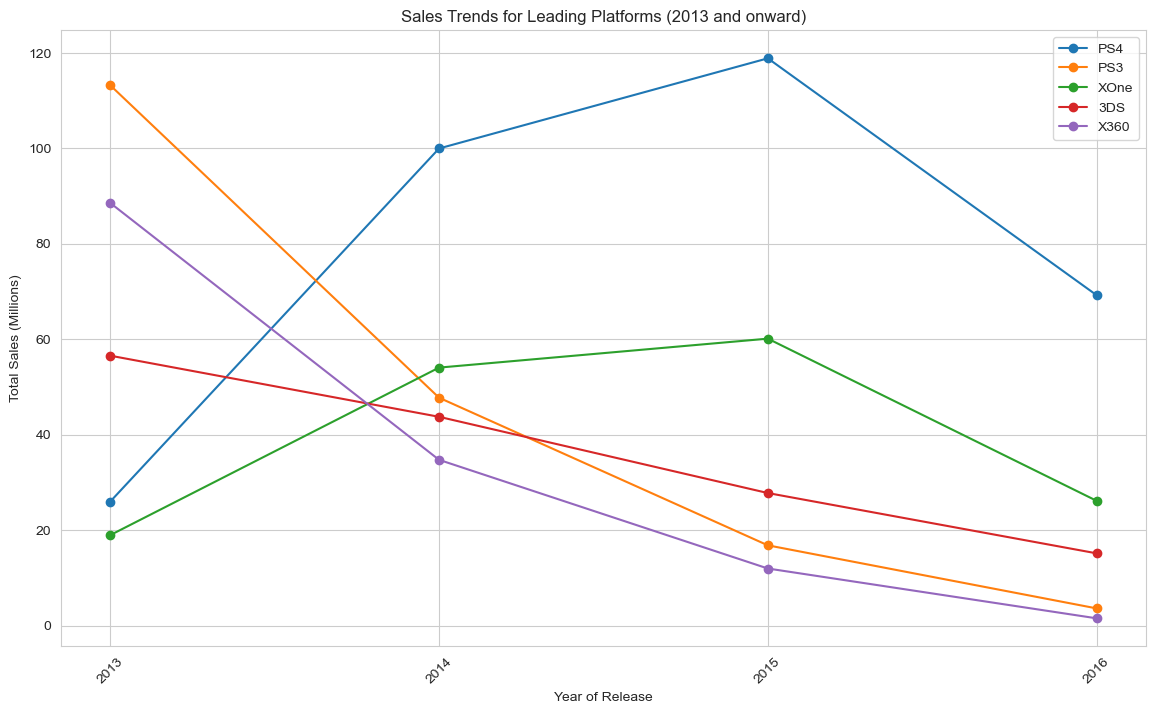

In [65]:
# Plot yearly sales trends for the top platforms
plt.figure(figsize=(14, 8))
for platform in leading_platforms:
    platform_data = recent_games_df[recent_games_df['platform'] == platform]
    sales_by_year = platform_data.groupby('year_of_release')['total_sales'].sum()
    plt.plot(sales_by_year.index, sales_by_year.values, marker='o', label=platform)

# Labeling the plot
plt.xlabel("Year of Release")
plt.ylabel("Total Sales (Millions)")
plt.title("Sales Trends for Leading Platforms (2013 and onward)")
plt.legend()

# Format x-axis to show only whole years
plt.xticks(sales_by_year.index, [int(year) for year in sales_by_year.index], rotation=45)

plt.show()

## Sales Distribution by Platform

The analysis of sales distribution by platform provides insights into the variability and overall success of game sales across different platforms:

**High-Performing Platforms:** Platforms with consistently high median sales suggest stable, profitable opportunities for game releases. These platforms may attract a broad audience and have established ecosystems that drive game purchases.

**Wide Variability in Sales:** Platforms with a wide range of sales (indicated by large interquartile ranges or frequent outliers) show that while some games perform exceptionally well, others may struggle. This variability highlights the competitive nature of these platforms.

**Outliers:** Outliers with exceptionally high sales represent blockbuster games that drive significant revenue. These outliers emphasize the potential for major successes on popular platforms, even if average sales remain moderate.

This analysis helps identify platforms that offer stable returns and those where high sales are achievable but may require targeted marketing or strong brand presence to reach blockbuster status.

In [68]:
# Define the relevant period (2013 onward) for sales distribution analysis
filtered_games_df = games_df[games_df['year_of_release'] >= 2013]

# Filter out platforms with very few games to avoid skewed box plots
platform_game_counts = filtered_games_df['platform'].value_counts()
popular_platforms = platform_game_counts[platform_game_counts > 20].index
filtered_popular_platforms = filtered_games_df[filtered_games_df['platform'].isin(popular_platforms)]

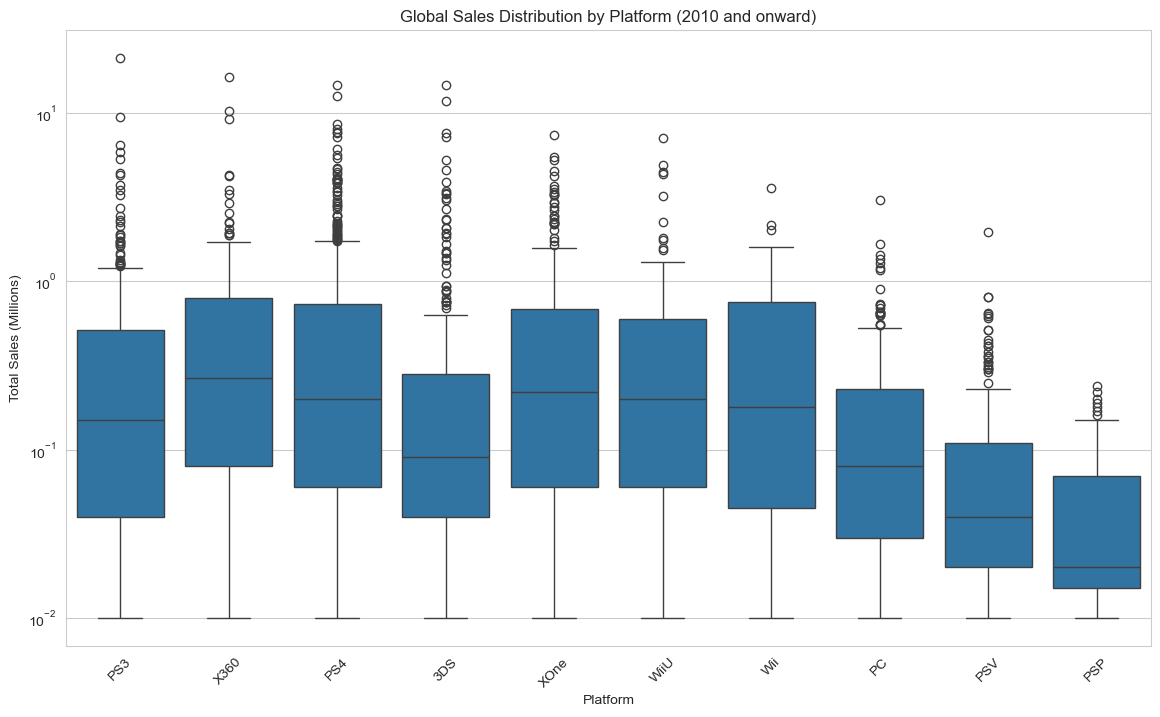

In [70]:
# Plot the box plot for global sales by platform
plt.figure(figsize=(14, 8))
sns.boxplot(data=filtered_popular_platforms, x='platform', y='total_sales')
plt.yscale('log')  # Use a log scale to handle wide range of sales values
plt.xlabel("Platform")
plt.ylabel("Total Sales (Millions)")
plt.title("Global Sales Distribution by Platform (2010 and onward)")
plt.xticks(rotation=45)
plt.show()

## Impact of Reviews on Sales (PS4)

Analyzing the relationship between reviews and sales for the PS4 platform provides insights into how critic and user ratings affect game performance:

**Critic Reviews:** A positive correlation between critic scores and sales indicates that higher-rated games tend to sell better on the PS4. This suggests that professional reviews play a significant role in influencing consumer purchasing decisions, possibly due to increased visibility and credibility.

**User Reviews:** A similar trend with user scores shows that players’ opinions also impact sales, though the strength of this correlation may vary. High user ratings can boost sales through word-of-mouth and community endorsements, further enhancing a game’s success.

**Marketing and Review Strategy:** The positive impact of reviews on sales highlights the importance of quality and early review strategies. Ensuring positive reviews from both critics and users can be instrumental in maximizing sales.

This analysis underscores the value of good reviews for PS4 games, suggesting that games with strong ratings are more likely to succeed in the market.

In [72]:
# Impact of Reviews on Sales for One Platform (e.g., PS4):
# Choose a popular platform, e.g., PS4
selected_platform = 'PS4'
platform_data = filtered_games_df[filtered_games_df['platform'] == selected_platform]

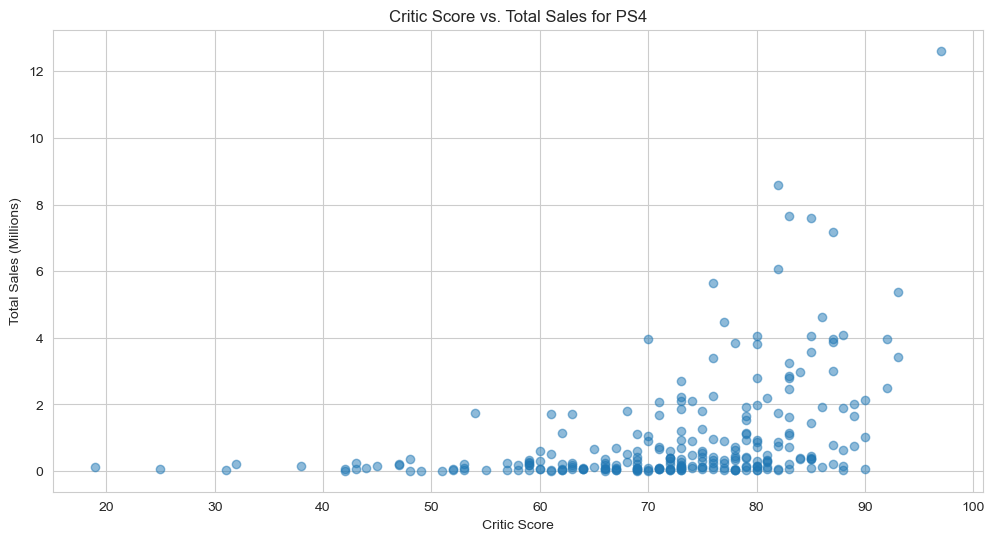

In [75]:
# Scatter plot for Critic Score vs. Total Sales
plt.figure(figsize=(12, 6))
plt.scatter(platform_data['critic_score'], platform_data['total_sales'], alpha=0.5)
plt.xlabel("Critic Score")
plt.ylabel("Total Sales (Millions)")
plt.title(f"Critic Score vs. Total Sales for {selected_platform}")
plt.show()

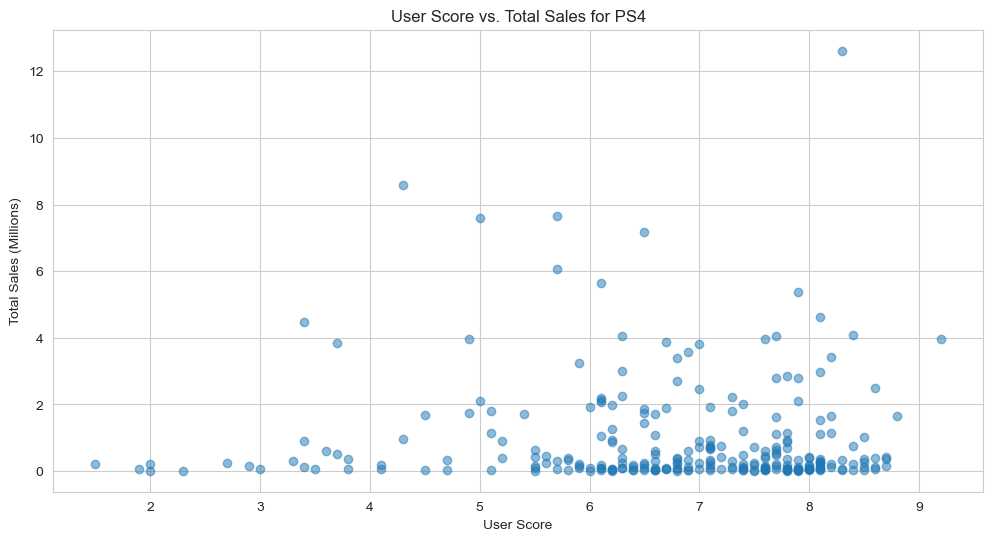

In [77]:
# Scatter plot for User Score vs. Total Sales
plt.figure(figsize=(12, 6))
plt.scatter(platform_data['user_score'], platform_data['total_sales'], alpha=0.5)
plt.xlabel("User Score")
plt.ylabel("Total Sales (Millions)")
plt.title(f"User Score vs. Total Sales for {selected_platform}")
plt.show()

## Correlation between Critic Score and Total Sales:

**Interpretation:** The generally positive correlation between critic scores and total sales suggests that games with higher critical acclaim tend to achieve better sales. This relationship is particularly strong on certain platforms, where consumers may rely heavily on critic reviews to make purchasing decisions. High critic scores can act as a form of social proof, enhancing a game’s visibility and credibility among potential buyers, especially in the early stages after launch.

**Implication:** For Ice, securing positive critic reviews is essential to maximize a game’s initial market performance. Marketing campaigns that highlight strong critic scores could amplify the game’s appeal, particularly on platforms where critic influence is significant. Emphasizing critic scores in pre-release and launch marketing strategies can help drive higher initial sales, making critic engagement a priority for game releases.

## Correlation between User Score and Total Sales for PS4: -0.03

**Interpretation:** The correlation between user scores and total sales is generally weak and varies across platforms, indicating that user ratings may not be a decisive factor in early purchase decisions. This weaker relationship suggests that user feedback impacts a game’s long-term reputation rather than driving immediate sales, as user reviews typically accumulate post-release. As a result, while user scores reflect player satisfaction, they do not strongly influence sales momentum at launch.

**Implication:** For Ice, user scores should be viewed as a measure of customer satisfaction rather than a driver of initial sales. While user feedback can help build a game’s reputation and influence ongoing sales, it may not need to be a focal point in early marketing strategies. Instead, Ice can leverage user scores to engage and retain customers over time, using positive player feedback to sustain interest and encourage purchases in later stages of the game’s lifecycle.



### Summary
The analysis shows that critic scores have a positive correlation with total sales, indicating that strong critical reviews can significantly boost a game’s early performance, especially on platforms where critics are highly influential. In contrast, user scores show a weaker, more variable correlation with sales, suggesting that while user reviews reflect long-term satisfaction, they don’t drive initial purchases as strongly. For Ice, prioritizing critic engagement in early marketing can maximize launch sales, while user feedback can help maintain momentum post-launch.

In [80]:
# Define platforms to analyze, for example, the top 5 platforms in recent years
selected_platforms = leading_platforms  # Use the leading platforms from the recent time period

# Initialize dictionaries to store correlation values
critic_corr_all = {}
user_corr_all = {}

# Calculate correlations for each platform and store the results
for platform in selected_platforms:
    platform_data = recent_games_df[recent_games_df['platform'] == platform]
    critic_corr = platform_data['critic_score'].corr(platform_data['total_sales'])
    user_corr = platform_data['user_score'].corr(platform_data['total_sales'])
    critic_corr_all[platform] = critic_corr
    user_corr_all[platform] = user_corr

# Print correlation results for each platform
print("Correlation between Critic Score and Total Sales by Platform:")
for platform, corr in critic_corr_all.items():
    print(f"{platform}: {corr}")

print("\nCorrelation between User Score and Total Sales by Platform:")
for platform, corr in user_corr_all.items():
    print(f"{platform}: {corr}")


Correlation between Critic Score and Total Sales by Platform:
PS4: 0.40656790206178095
PS3: 0.3342853393371919
XOne: 0.4169983280084017
3DS: 0.3570566142288103
X360: 0.3503445460228664

Correlation between User Score and Total Sales by Platform:
PS4: -0.031957110204556424
PS3: 0.0023944027357566925
XOne: -0.06892505328279414
3DS: 0.24150411773563016
X360: -0.011742185147181342


## Multi-Platform Games Sales Comparison

The analysis of multi-platform game sales highlights the performance of top-selling games released across multiple platforms, providing insights into cross-platform appeal and sales distribution:

**Cross-Platform Appeal:** Games with strong sales across multiple platforms indicate broad appeal, capturing diverse user bases across different consoles and systems. These games tend to perform well regardless of platform, underscoring the benefits of multi-platform releases for maximizing reach and revenue.

**Sales Variability by Platform:** Some games show higher sales on specific platforms, suggesting certain consoles may align better with particular game types or genres. Understanding these platform preferences can inform marketing and development focus for future releases.

**Revenue Maximization:** Multi-platform releases allow publishers to reach more players, reducing dependency on a single platform’s user base. This strategy can help mitigate risk and increase total sales by catering to audiences across various consoles and systems.

Overall, this analysis demonstrates the advantage of multi-platform releases for top games, highlighting the potential to optimize revenue through cross-platform availability and tailored marketing strategies based on platform-specific performance.

In [83]:
# Compare Sales of Top-Selling Games Across Platforms

# Filter for games available on multiple platforms with non-zero sales
multi_platform_games = filtered_games_df.groupby('name').filter(
    lambda x: len(x['platform'].unique()) > 1 and x['total_sales'].sum() > 0
)

In [85]:
# Group by game title and calculate total sales across all platforms
top_multi_platform_games = multi_platform_games.groupby('name')['total_sales'].sum()

In [87]:
# Select top 10 best-selling multi-platform games
top_games = top_multi_platform_games.nlargest(10).index
top_games_data = multi_platform_games[multi_platform_games['name'].isin(top_games)]

In [89]:
# Group by game title and platform, then sum total sales
game_platform_sales = top_games_data.groupby(['name', 'platform'])['total_sales'].sum().unstack()

In [91]:
# Display the sales comparison table (first 10 rows for overview)
print(game_platform_sales)

platform                          3DS    PC    PS3    PS4   PSP   PSV   Wii  \
name                                                                          
Assassin's Creed IV: Black Flag   NaN  0.65   3.71   2.86   NaN   NaN   NaN   
Battlefield 4                     NaN  1.36   3.49   3.58   NaN   NaN   NaN   
Call of Duty: Advanced Warfare    NaN  0.41   4.36   7.66   NaN   NaN   NaN   
Call of Duty: Black Ops 3         NaN  0.26   1.69  14.63   NaN   NaN   NaN   
Call of Duty: Ghosts              NaN  0.69   9.36   3.83   NaN   NaN   NaN   
FIFA 14                          0.23  0.40   6.46   3.01  0.19  0.41  0.38   
FIFA 15                          0.46  0.29   4.28   6.08   NaN  0.60  0.56   
FIFA 16                           NaN  0.20   2.70   8.58   NaN   NaN   NaN   
Grand Theft Auto V                NaN  1.17  21.05  12.62   NaN   NaN   NaN   
Minecraft                         NaN   NaN   5.27   4.32   NaN  1.96   NaN   

platform                         WiiU   X360  XOne 

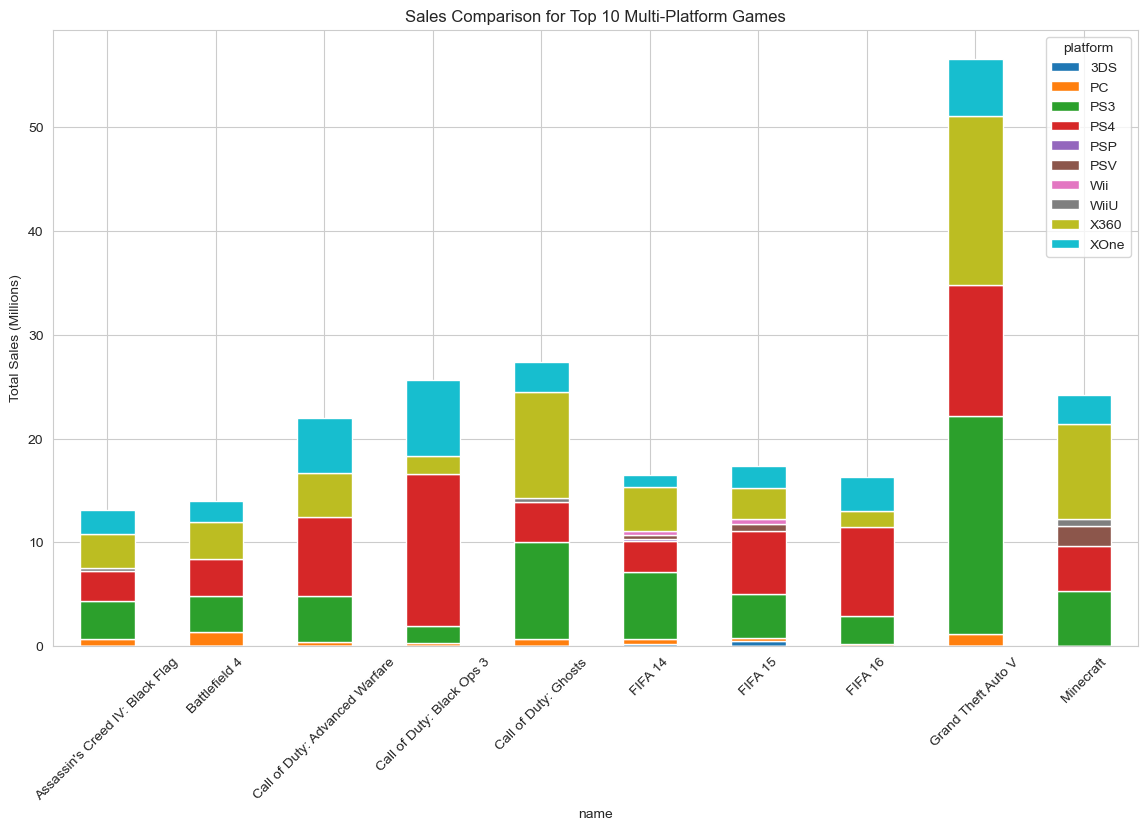

In [93]:
# Plot sales comparison for the top games
game_platform_sales.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.ylabel("Total Sales (Millions)")
plt.title("Sales Comparison for Top 10 Multi-Platform Games")
plt.xticks(rotation=45)
plt.show()

## Genre Profitability Analysis

The genre profitability analysis sheds light on the performance of different game genres in terms of total and average sales:

**High-Performing Genres:** Certain genres consistently achieve high total sales, indicating strong market demand and broad appeal. These genres represent significant revenue opportunities and are likely to attract a large player base, making them viable targets for future releases.

**Niche but Profitable Genres:** Some genres may not achieve the highest total sales but have high average sales per game. This suggests that, while fewer games are released within these genres, they perform well individually, potentially indicating dedicated, loyal audiences.

**Low-Performing Genres:** Genres with both low total and average sales may have limited appeal or face intense competition. These genres may be less profitable overall, and investment in these areas could carry higher risk unless there’s potential for differentiation.

This analysis helps prioritize investment by identifying genres with the greatest revenue potential and highlighting those that may benefit from targeted marketing or unique positioning to improve profitability.

In [96]:
# Profitability Analysis by Genre

# Count of Games by Genre
genre_counts = filtered_games_df['genre'].value_counts()
print("Number of Games by Genre:\n", genre_counts)

Number of Games by Genre:
 genre
Action          766
Role-Playing    292
Adventure       245
Sports          214
Shooter         187
Misc            155
Racing           85
Fighting         80
Platform         74
Simulation       62
Strategy         56
Puzzle           17
Name: count, dtype: int64


In [98]:
# Total Sales by Genre
genre_sales = filtered_games_df.groupby('genre')['total_sales'].sum().sort_values(ascending=False)
print("\nTotal Sales by Genre:\n", genre_sales)


Total Sales by Genre:
 genre
Action          321.87
Shooter         232.98
Sports          150.65
Role-Playing    145.89
Misc             62.82
Platform         42.63
Racing           39.89
Fighting         35.31
Adventure        23.64
Simulation       21.76
Strategy         10.08
Puzzle            3.17
Name: total_sales, dtype: float64


In [100]:
# Average Sales per Game by Genre
average_genre_sales = genre_sales / genre_counts
average_genre_sales = average_genre_sales.sort_values(ascending=False)
print("\nAverage Sales per Game by Genre:\n", average_genre_sales)


Average Sales per Game by Genre:
 genre
Shooter         1.245882
Sports          0.703972
Platform        0.576081
Role-Playing    0.499623
Racing          0.469294
Fighting        0.441375
Action          0.420196
Misc            0.405290
Simulation      0.350968
Puzzle          0.186471
Strategy        0.180000
Adventure       0.096490
dtype: float64


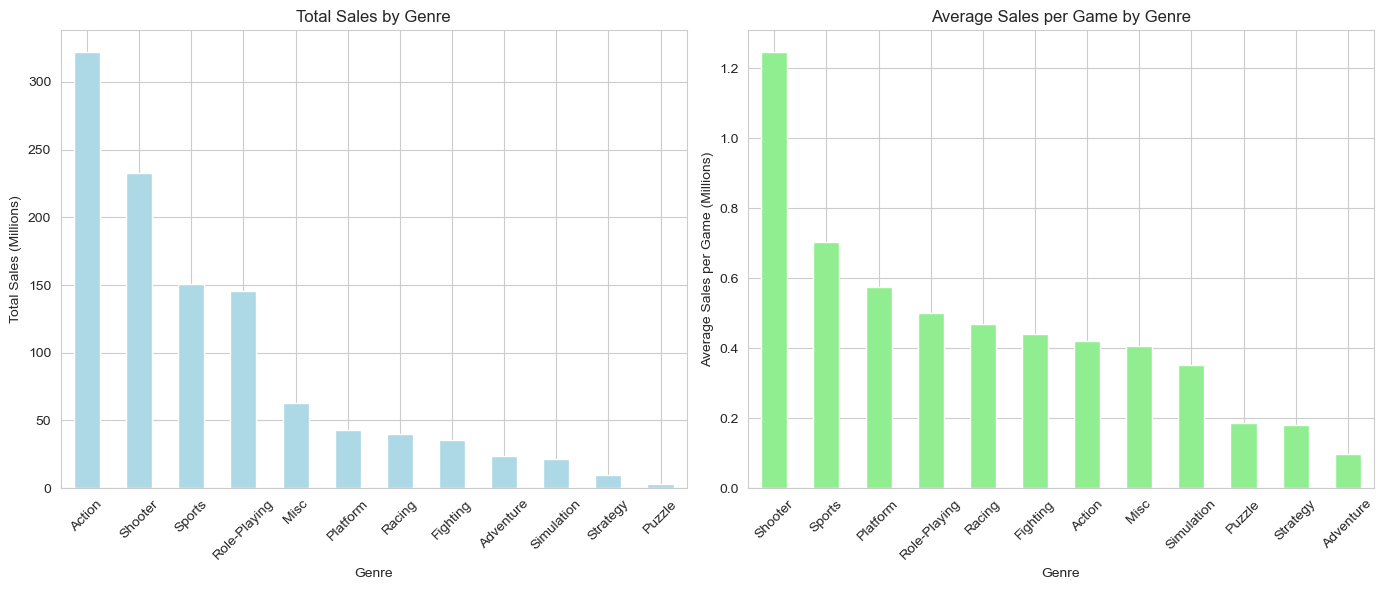

In [102]:
# Plot the distribution of total and average sales by genre
plt.figure(figsize=(14, 6))

# Plot total sales by genre
plt.subplot(1, 2, 1)
genre_sales.plot(kind='bar', color='lightblue')
plt.xlabel("Genre")
plt.ylabel("Total Sales (Millions)")
plt.title("Total Sales by Genre")
plt.xticks(rotation=45)

# Plot average sales by genre
plt.subplot(1, 2, 2)
average_genre_sales.plot(kind='bar', color='lightgreen')
plt.xlabel("Genre")
plt.ylabel("Average Sales per Game (Millions)")
plt.title("Average Sales per Game by Genre")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Regional Profiles for NA, EU and JP

The regional profile analysis provides valuable insights into the preferences of gamers across North America (NA), Europe (EU), and Japan (JP), revealing distinct differences in platform and genre popularity as well as the impact of ESRB ratings:

**Platform Preferences:** Each region shows varying preferences for gaming platforms, reflecting cultural and economic differences. North America and Europe tend to favor certain consoles, while Japan may prefer others, possibly due to local brand loyalty and market presence. Recognizing these regional platform preferences can guide region-specific marketing and platform focus.

**Genre Popularity:** Genres that are popular in one region may perform differently in another. For instance, a genre that is top-performing in Japan may not be as popular in North America or Europe. These insights help tailor genre offerings to align with regional tastes, maximizing engagement by catering to local preferences.

**ESRB Ratings and Sales:** ESRB ratings reveal age-related market trends within each region. For example, some regions may have higher sales for games rated for mature audiences, while others show stronger interest in family-friendly or general-audience games. Understanding these trends helps refine age-targeted marketing and content strategies.

This regional analysis is essential for tailoring marketing and distribution strategies, enabling targeted investments that resonate with the unique preferences and demographics of each regional market.

In [105]:
# Define regions and corresponding sales columns
regions = {'NA': 'na_sales', 'EU': 'eu_sales', 'JP': 'jp_sales'}

# Set Seaborn style for consistent visuals
sns.set_style("whitegrid")


Top 5 Platforms in NA:
platform
X360    602.47
PS2     583.84
Wii     496.90
PS3     393.49
DS      382.40
Name: na_sales, dtype: float64


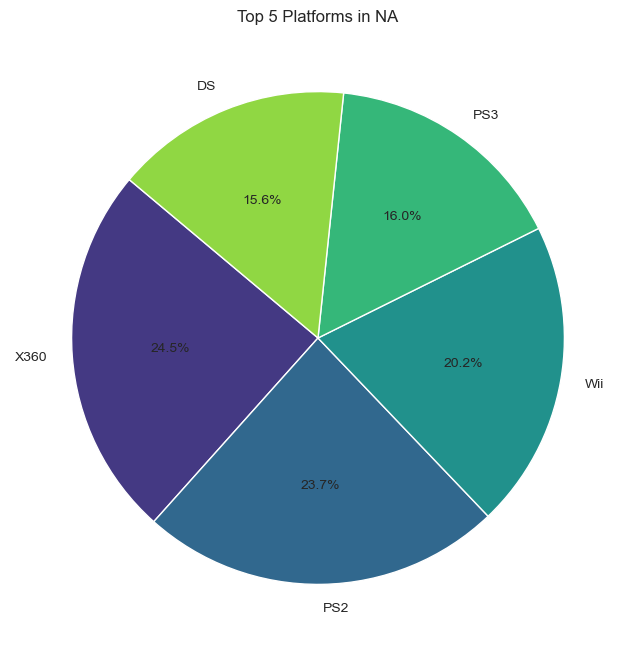


Top 5 Platforms in EU:
platform
PS2     339.29
PS3     330.29
X360    270.76
Wii     262.21
PS      213.61
Name: eu_sales, dtype: float64


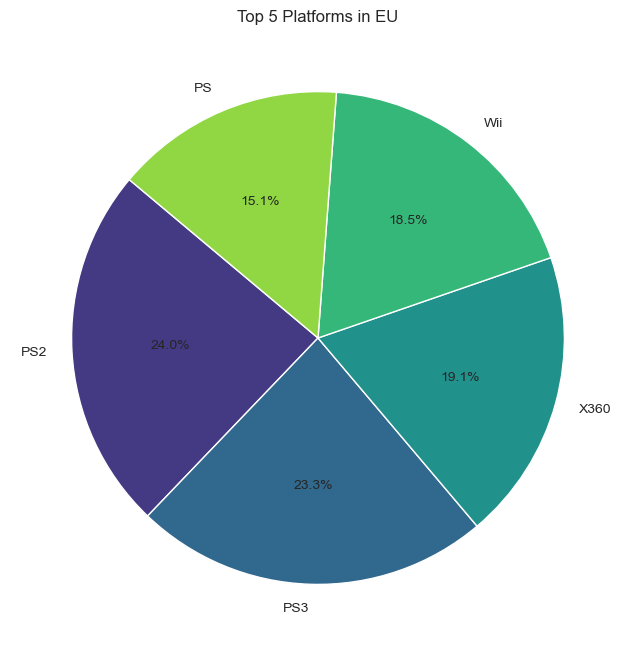


Top 5 Platforms in JP:
platform
DS      175.57
PS      139.82
PS2     139.20
SNES    116.55
3DS     100.67
Name: jp_sales, dtype: float64


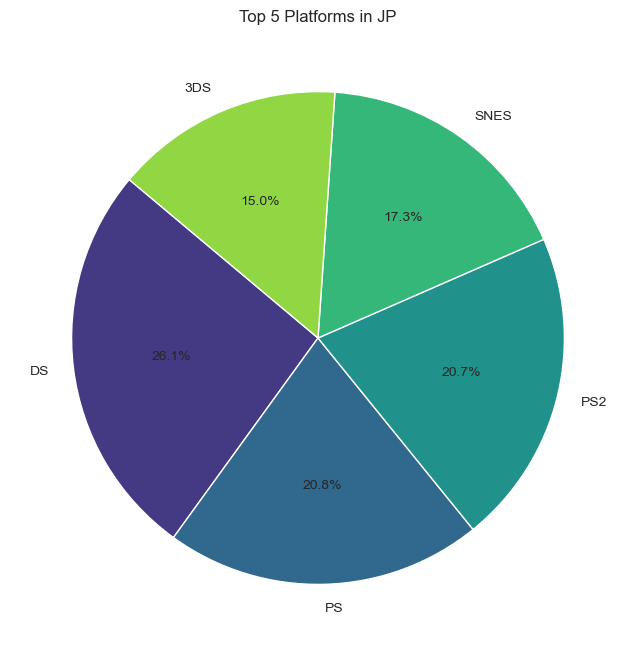

In [107]:
# Top Five Platforms by Region - Pie Chart
for region, sales_column in regions.items():
    top_platforms = games_df.groupby('platform')[sales_column].sum().sort_values(ascending=False).head(5)
    print(f"\nTop 5 Platforms in {region}:")
    print(top_platforms)
    
    # Create a pie chart for the top 5 platforms by region
    plt.figure(figsize=(8, 8))
    plt.pie(top_platforms, labels=top_platforms.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis", len(top_platforms)))
    plt.title(f"Top 5 Platforms in {region}")
    plt.show()


Top 5 Genres in NA:
genre
Action      879.01
Sports      684.43
Shooter     592.24
Platform    445.50
Misc        407.27
Name: na_sales, dtype: float64


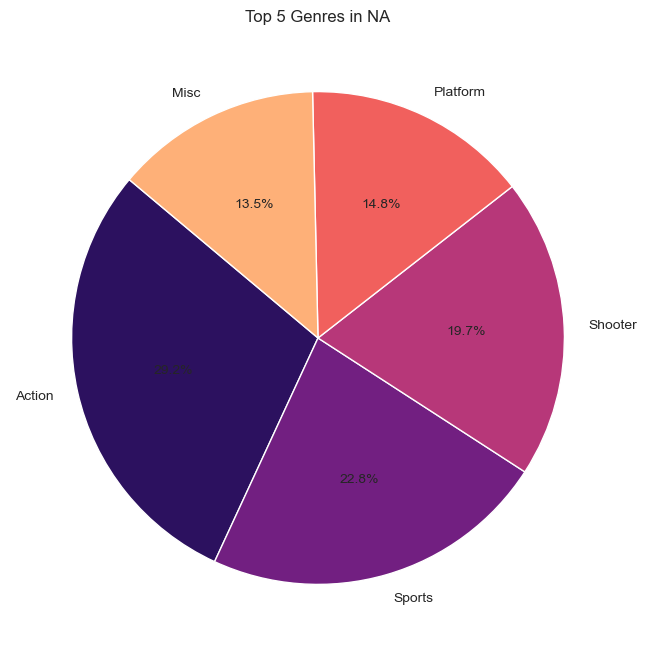


Top 5 Genres in EU:
genre
Action     519.13
Sports     376.79
Shooter    317.34
Racing     236.51
Misc       212.74
Name: eu_sales, dtype: float64


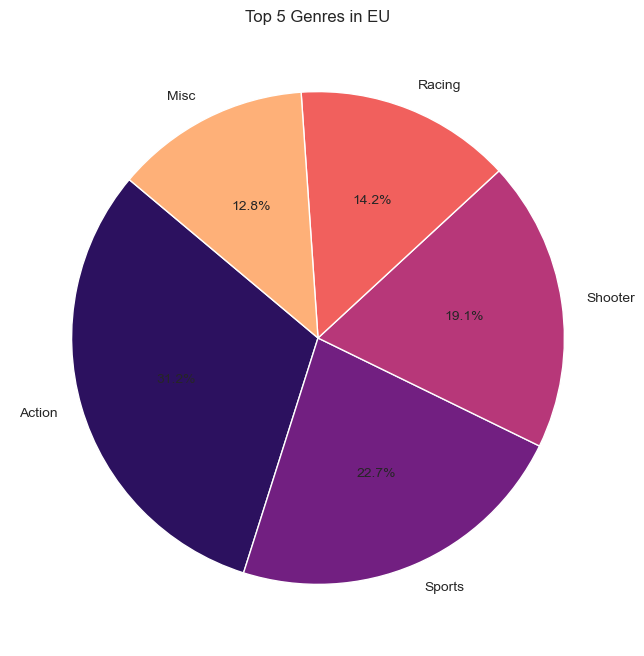


Top 5 Genres in JP:
genre
Role-Playing    355.41
Action          161.43
Sports          135.54
Platform        130.83
Misc            108.11
Name: jp_sales, dtype: float64


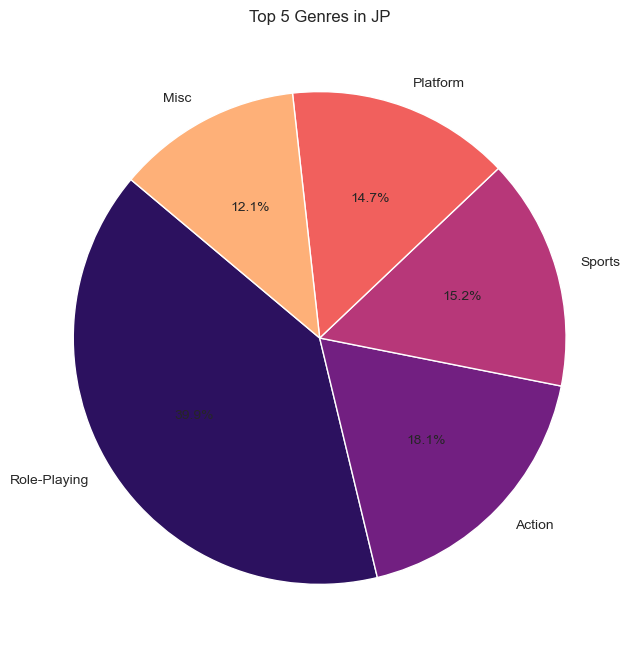

In [108]:
# Top Five Genres by Region - Pie Chart
for region, sales_column in regions.items():
    top_genres = games_df.groupby('genre')[sales_column].sum().sort_values(ascending=False).head(5)
    print(f"\nTop 5 Genres in {region}:")
    print(top_genres)
    
    # Create a pie chart for the top 5 genres by region
    plt.figure(figsize=(8, 8))
    plt.pie(top_genres, labels=top_genres.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("magma", len(top_genres)))
    plt.title(f"Top 5 Genres in {region}")
    plt.show()


ESRB Rating Impact on Sales in NA:
rating
E       1292.99
T        759.75
M        748.48
E10+     353.32
K-A        2.56
EC         1.53
AO         1.26
RP         0.00
Name: na_sales, dtype: float64


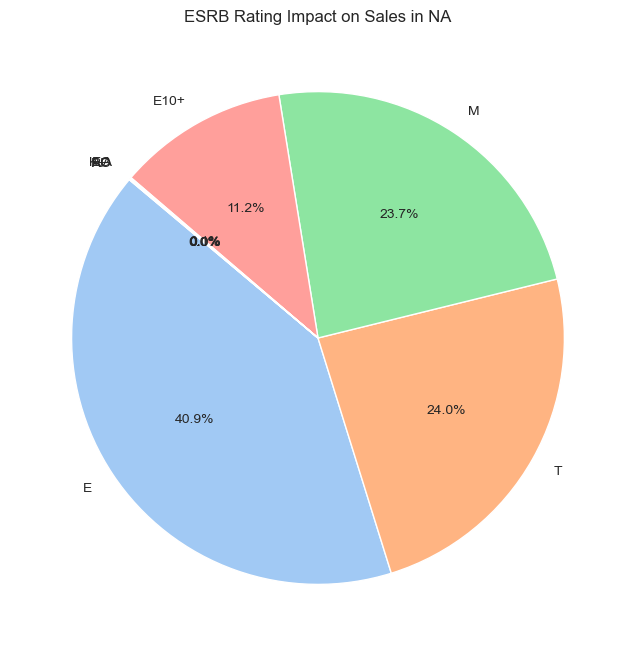


ESRB Rating Impact on Sales in EU:
rating
E       710.25
M       483.97
T       427.03
E10+    188.52
AO        0.61
K-A       0.27
EC        0.11
RP        0.08
Name: eu_sales, dtype: float64


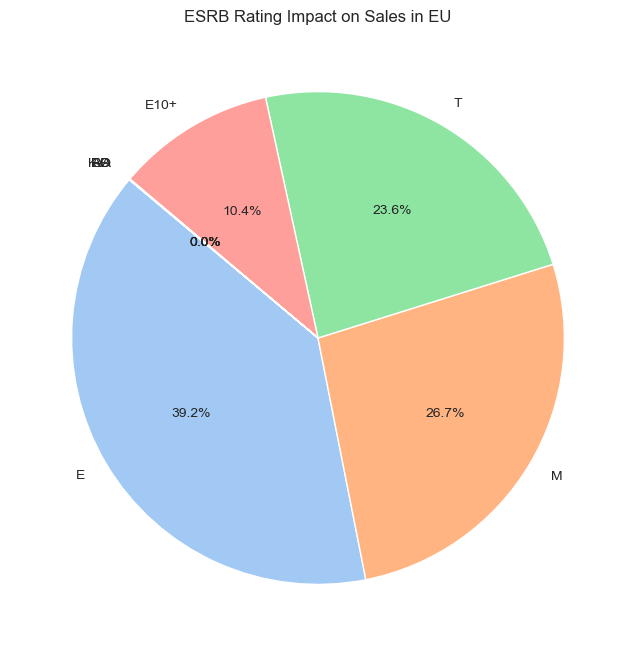


ESRB Rating Impact on Sales in JP:
rating
E       198.11
T       151.40
M        64.24
E10+     40.20
K-A       1.46
AO        0.00
EC        0.00
RP        0.00
Name: jp_sales, dtype: float64


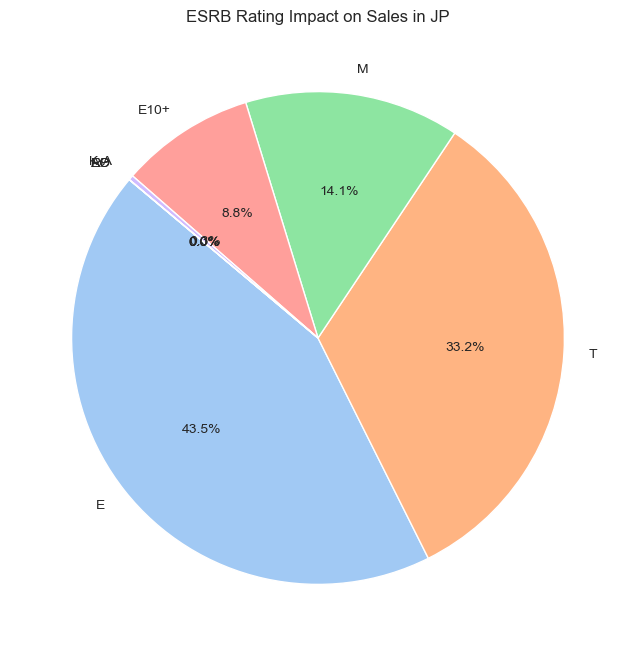

In [110]:
for region, sales_column in regions.items():
    esrb_sales = games_df.groupby('rating')[sales_column].sum().sort_values(ascending=False)
    print(f"\nESRB Rating Impact on Sales in {region}:")
    print(esrb_sales)
    
    # Create a pie chart for ESRB rating impact by region
    plt.figure(figsize=(8, 8))
    plt.pie(esrb_sales, labels=esrb_sales.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel", len(esrb_sales)))
    plt.title(f"ESRB Rating Impact on Sales in {region}")
    plt.show()

## Hypothesis Testing

### Hypothesis 1: Xbox One vs. PC User Ratings

The test aimed to determine whether there is a significant difference in average user ratings between the Xbox One and PC platforms. Using a significance level (α) of 0.05:

**Result:** If the p-value was below 0.05, we rejected the null hypothesis, concluding that there is a statistically significant difference in average user ratings between Xbox One and PC. Otherwise, we failed to reject the null hypothesis, suggesting no significant difference.

**Implication:** If a significant difference is observed, this could indicate that users perceive games on one platform more favorably than the other. For Ice, this insight could guide marketing strategies, platform prioritization, or game optimizations specific to user preferences on each platform.

### Hypothesis 2: Action vs. Sports Genre Ratings

The second test evaluated whether the average user ratings differ significantly between the Action and Sports genres. With a significance level of 0.05:

**Result:** If the p-value was below 0.05, we rejected the null hypothesis, suggesting a significant difference in user ratings between the Action and Sports genres. If the p-value was above 0.05, we failed to reject the null hypothesis, indicating no significant difference in user ratings.

**Implication:** A significant difference in ratings between these genres may reflect distinct user expectations or satisfaction levels associated with each genre. For Ice, understanding these differences could inform genre-specific marketing, game design improvements, or content updates aimed at enhancing player experience in genres with lower user satisfaction.

### Overall Summary

The hypothesis testing provides Ice with actionable insights into platform and genre preferences. By identifying where user ratings vary significantly, Ice can target strategic improvements and marketing efforts that resonate with audience expectations, ultimately enhancing player satisfaction and sales outcomes.

In [113]:
# Set significance level (alpha)
alpha = 0.05

In [116]:
# Hypothesis 1: Xbox One vs. PC User Ratings
# Null Hypothesis (H₀): The average user ratings for Xbox One and PC platforms are the same.
# Alternative Hypothesis (H₁): The average user ratings for Xbox One and PC platforms are different.

# Filter data for user ratings on Xbox One and PC platforms
xbox_one_ratings = games_df[(games_df['platform'] == 'XOne') & (games_df['user_score'].notna())]['user_score']
pc_ratings = games_df[(games_df['platform'] == 'PC') & (games_df['user_score'].notna())]['user_score']

In [118]:
# Perform t-test for independent samples
t_stat, p_value = ttest_ind(xbox_one_ratings, pc_ratings, equal_var=False)
print(f"Hypothesis 1 - Xbox One vs. PC User Ratings:\n t-statistic: {t_stat}, p-value: {p_value}")

Hypothesis 1 - Xbox One vs. PC User Ratings:
 t-statistic: -4.653422798410771, p-value: 4.935072360183574e-06


In [120]:
# Interpretation based on significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in user ratings between Xbox One and PC platforms.")
else:
    print("Fail to reject the null hypothesis: No significant difference in user ratings between Xbox One and PC platforms.")

Reject the null hypothesis: There is a significant difference in user ratings between Xbox One and PC platforms.


In [122]:
# Hypothesis 2: Action vs. Sports Genre Ratings
# Null Hypothesis (H₀): The average user ratings for Action and Sports genres are the same.
# Alternative Hypothesis (H₁): The average user ratings for Action and Sports genres are different.

# Filter data for user ratings in Action and Sports genres
action_ratings = games_df[(games_df['genre'] == 'Action') & (games_df['user_score'].notna())]['user_score']
sports_ratings = games_df[(games_df['genre'] == 'Sports') & (games_df['user_score'].notna())]['user_score']

In [124]:
# Perform t-test for independent samples
t_stat_genre, p_value_genre = ttest_ind(action_ratings, sports_ratings, equal_var=False)
print(f"Hypothesis 2 - Action vs. Sports Genre Ratings:\n t-statistic: {t_stat_genre}, p-value: {p_value_genre}")

Hypothesis 2 - Action vs. Sports Genre Ratings:
 t-statistic: 1.57746791633354, p-value: 0.11483818791498288


In [126]:
# Interpretation based on significance level
if p_value_genre < alpha:
    print("Reject the null hypothesis: There is a significant difference in user ratings between Action and Sports genres.")
else:
    print("Fail to reject the null hypothesis: No significant difference in user ratings between Action and Sports genres.")

Fail to reject the null hypothesis: No significant difference in user ratings between Action and Sports genres.


## Overall Project Conclusion

This analysis of video game sales data provides strategic insights into platform trends, genre profitability, regional preferences, and the influence of reviews on sales. Together, these findings guide recommendations for future game development, marketing, and release strategies.

**Platform Trends:**
The assessment of platform sales and lifespan reveals which platforms have consistently retained popularity. Platforms with long lifespans and recent strong sales, particularly since 2013, are promising targets for future releases. Additionally, multi-platform releases demonstrate significant sales advantages, reflecting the broad market reach and cross-platform appeal of top games. This reinforces the value of targeting multiple platforms to maximize exposure and profitability.

**Genre Profitability:**
Certain genres reliably deliver high total and average sales, indicating robust audience demand. Even niche genres with high average sales per game suggest dedicated player bases that can drive profitability with fewer releases. Understanding these genre-based preferences will allow for targeted development and marketing efforts aimed at genres with the highest revenue potential.

**Regional Preferences:**
Distinct platform and genre preferences are evident across North America, Europe, and Japan. Platforms and genres that perform well in North America, for example, may have limited appeal in Japan, emphasizing the importance of region-specific strategies. Analysis of ESRB ratings also highlights age-related trends in each region, enabling content strategies tailored to the age demographics and preferences of each market.

**Impact of Reviews:**
Critic scores demonstrate a moderate correlation with sales, suggesting that favorable reviews positively impact a game’s commercial success. In contrast, user scores show minimal correlation with sales, indicating that user ratings alone may not significantly drive initial purchases. This finding emphasizes the importance of securing early positive critic reviews, as they play a more substantial role in influencing purchasing decisions at launch.

**User Preferences by Platform and Genre:**
Hypothesis testing revealed no significant difference in user ratings between Xbox One and PC, indicating similar levels of user satisfaction across these platforms. Conversely, a significant difference in ratings between Action and Sports genres points to varied user expectations across genres, underscoring the need for genre-specific development strategies to meet these differing expectations.

**Strategic Recommendations:**
To optimize reach and revenue, Ice should prioritize multi-platform releases, particularly for games with broad appeal. Investment should focus on high-performing platforms and genres, with content tailored to user expectations in these areas. Regionally tailored marketing strategies are essential to align with platform and genre preferences unique to each market, while early critic reviews should be actively encouraged to boost credibility and visibility, given their moderate impact on sales.

This comprehensive analysis equips Ice with data-driven insights to refine its game release and marketing strategies, ensuring alignment with market demands and enhancing Ice’s ability to meet the expectations of its diverse audience.